# Multi-region Sparse Component Analysis (**mSCA**)

**mSCA** is a dimensionality reduction tool specifically designed for analyzing data from multiple brain regions.

**mSCA** has three defining features:

1.  **Inferring latent factors that occur sparsely in time:** For example, it can demarcate movement-related activity from preparatory activity, facilitating interpretation.

2.  **Identifying region-specific or shared latent factors:** mSCA determines whether each inferred latent factor is unique to a given brain region or shared across multiple regions.

3.  **Quantifying time-delays for shared latent factors:** For latent factors shared across regions, mSCA identifies the time-delays at which they appear in each region, revealing the correlational flow of information between brain regions.

This notebook will guide you through the basic functionality of mSCA and should be copied and adapted to get started with your own data. We will have an additional notebook walking through more rigorous (but more time-intensive) analyses in `./full_demo.ipynb`.

## Required package installations
* Follow the installation instructions in `README.md` before running the code below.

## Data formatting and example
* In order to fit mSCA and infer latents, your data should be in the following format:
    ```
    X = { 
        "region_1": [trial_1, trial_2, ..., trial_M], 
        "region_2": [trial_1, trial_2, ..., trial_M]
    }
    ```
* The keys of `X` should correspond to the names of the regions in your dataset.
* The values of `X` should be lists of `np.float32` arrays of shape `(t_j x N_i)`.
    * `t_j` is the number of time-points on trial `j`.
    * `N_i` is the number of neurons in region `i`.

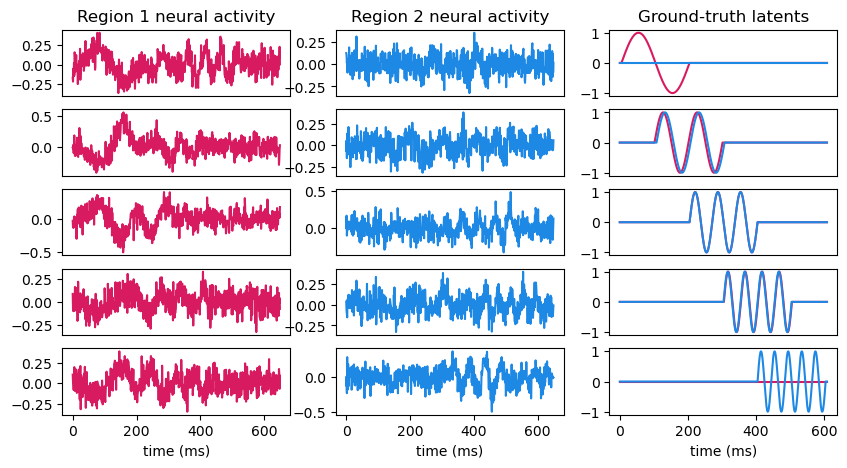

In [1]:
import matplotlib.pyplot as plt
from msca import *

# NOTE: we have manually made one of the time-delays in the ground-truth dataset
#       = 1 time bin, in order to showcase the high temporal resolution at which
#       mSCA performs.

# Generate noisy simulated firing-rates, ground-truth latents, and delays
X, Z_gt, delays_gt = simulate_trial_averages()

# Visualization + example accessing attributes of X
colors = ["#D81B60", "#1E88E5"]
num_viz = 5
fig, axs = plt.subplots(num_viz, 3, figsize=(10, 5))
for i in range(num_viz):
    axs[i, 0].plot(X["X0"][0][:, i], c=colors[0])
    axs[i, 1].plot(X["X1"][0][:, i], c=colors[1])
    axs[i, 2].plot(Z_gt["Z0"][:, i], c=colors[0])
    axs[i, 2].plot(Z_gt["Z1"][:, i], c=colors[1])

    if i == 0:
        axs[i, 0].set_title("Region 1 neural activity")
        axs[i, 1].set_title("Region 2 neural activity")
        axs[i, 2].set_title("Ground-truth latents")

    if i < num_viz-1:
        axs[i, 0].set_xticks([])
        axs[i, 1].set_xticks([])
        axs[i, 2].set_xticks([])
    else:
        axs[i, 0].set_xlabel("time (ms)")
        axs[i, 1].set_xlabel("time (ms)")
        axs[i, 2].set_xlabel("time (ms)")

## Training mSCA

* We're now going to train mSCA, using 1 additional dimension than was used to generate the training data to illustrate that mSCA is robust to the number of dimensions specified.
* If your data hasn't been pre-smoothed or trial-averaged in any way, add `loss_func="Poisson"` to the arguments passed into `mSCA()`.
* If you want to toggle any of the following hyperparameters `lam_sparse`, `lam_orthog`, or `lam_region`, you can pass your desired value as an argument to `mSCA()`. It's a good idea to keep the values you use within the range [0.0, 1.0].

In [2]:
msca, losses = mSCA(n_components=5, n_epochs=4000).fit(X)

/Users/andrewulmer/nuin/research/mSCA/msca/architectures.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.model.weight = torch.tensor(V_combined, dtype=torch.float32)


Using region-weights = {'X0': 0.999693727533317, 'X1': 1.000306460187318}
Using lam_sparse = 0.05665862799905292
Using lam_orthog = 3175.7213829613934
Using lam_region = 151.69438359154447


100%|██████████| 4000/4000 [01:48<00:00, 36.72it/s]


## Visualize the losses to ensure the model converged

Text(0.5, 0, 'training epoch')

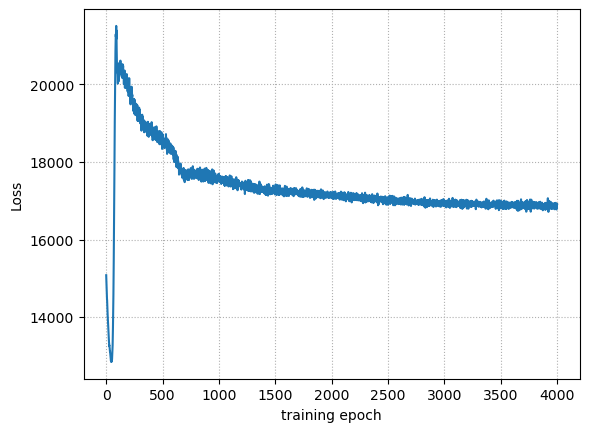

In [ ]:
# Concatenate and sum the losses (reconstruction, latent sparsity, region, sparsity, and orthogonality)
loss = np.stack([v for v in losses.values()], axis=1).sum(axis=1)
plt.plot(loss[100:]); # Avoiding weirdness in early training
plt.grid(ls=":");
plt.ylabel("Loss");
plt.xlabel("training epoch")

## Refining the trained mSCA model
* We don't want to interpret time-delays that do not generalize well to held-out data.
* To avoid this, and avoid holding out data from our analysis, we developed a bootstrapping approach that scores time-delays on how well they generalize to *pseudo*-held-out data.
    * The details of this will be covered in `full_demo.ipynb`.
* We can use the results from this approach to prune those time-delays that do not meaningfully improve our ability to reconstruct neural activity input to mSCA.
* Part of the pruning process involves setting a threshold value. A higher threshold value corresponds to a stricter criterion i.e.:
    * For a high threshold, a learned time-delay must substantially improve prediction performance of pseudo-held-out data.
    * For a lower threshold, a learned time-delay must only marginally improve prediction performance of pseudo-held-out data

In [ ]:
# Find the effect each time-delay has on reconstruction of pseudo-held-out
delay_effects = bootstrap_delays_decoder(msca, X)

# Set the threshold to use for pruning delays
threshold = 0.001

# Plot the distribition of delay effects for each dimension
plt.violinplot(
    [v for v in delay_effects.values()], positions=[k for k in delay_effects.keys()]
)
plt.grid(ls=":")
plt.xlabel("latent dimension")
plt.ylabel("delay effect score")
plt.axhline(y=threshold, ls=":", c="k")
plt.title("Delay effect distributions")

# Iterate through dimensions and prune out those delays that don't fit our criterion
for i in range(msca.n_components):
    mean, lower = mean_confidence_interval(delay_effects[i])
    if lower <= threshold:
        msca.model.filters.mus.data[i] = 0

## Inferring latents with the refined mSCA model

* We're now going to use mSCA to infer latents and compare them to the ground-truth latents and corresponding time-delays.
* **Note**:
    * The recovered latents might appear a little bent when compared to the ground-truth. This is due to the non-linearities in the encoder. On real datasets (non-simulated), we've seen these non-linearities help find sparser, more interpretable latents.
    * Also, the inferred latents may be flipped in sign (+1 or -1) when compared to the ground-truth.

In [ ]:
# First infer the latents
Z = msca.transform(X)

# Let's order the latents for the first trial by deflection time
idxs = detect_deflect(Z, msca, trial_num=0)

# Reorder the inferred latents for the first trial by deflection time
Z_reordered = {
    "X0": Z["X0"][0][:,idxs],
    "X1": Z["X1"][0][:,idxs]
}

colors = ["#D81B60", "#1E88E5"]
# fig, axs = plt.subplots(5, 2, figsize=(7, 5))

fig = plt.figure(figsize=(7, 5))

# Create a grid with n_components rows and 3 columns
gs = fig.add_gridspec(msca.n_components, 2, width_ratios=[1, 1])

# Retrieve the time-delays
delays = (msca.model.filters.mus.data[:, 1] - msca.model.filters.mus.data[:, 0])[idxs].tolist()

# Iterate through latent dimensions and plot
for i in range(5):

    ax = fig.add_subplot(gs[i,0])
    ax.plot(Z_reordered["X0"][:, i], c=colors[0])
    ax.plot(Z_reordered["X1"][:, i], c=colors[1])
    ax.set_title(f"Inferred delay: {delays[i]:.2f}")
    ax.set_ylim(-1.1,1.1)

    if i < 4:
        ax.set_xticks([])

    ax = fig.add_subplot(gs[i,1])
    ax.plot(Z_gt["Z0"][:, i], c=colors[0])
    ax.plot(Z_gt["Z1"][:, i], c=colors[1])
    ax.set_title(f"Ground-truth delay: {delays_gt[i]:.2f}")

    ax.set_ylim(-1.1, 1.1)

    if i < 4:
        ax.set_xticks([])

fig.tight_layout()

## Check prediction quality
* We're now going to look and see how well the reconstructed neural activity captures the neural activity we input to the model

In [ ]:
# Grab the reconstructions
X_hat = msca.predict(X)

# Check the quality of the reconstructions
plt.plot(X["X0"][0][msca.trunc, 0])
plt.plot(X_hat["X0"][0][:, 0])

## Working with real data

* TODO: add note about sparsity sweeping
* TODO: add note about bootstrapping approach vs. bi-cross-validation
* TODO: add note about quest